In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.feature_map import ChebRx
from squlearn.expectation_operator import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss, VarianceLoss
from squlearn.optimizers import SLSQP

Define parameterized quantum circuit $Q(x,\theta)$

In [2]:
executor = Executor("statevector_simulator")

Definition of the cost operator:
$\hat{H} = J \sum\limits_{i < j} Z_i Z_j + h\sum\limits_i Z_i + c$

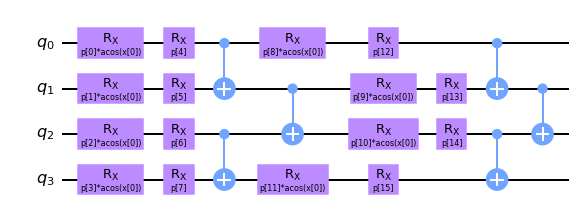

In [3]:
nqubits = 4

number_of_layers = 2
pqc = ChebRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw()

In [4]:
ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

SummedOp([
  1.0*p[0] * IIII,
  1.0*p[1] * IIIZ,
  1.0*p[1] * IIZI,
  1.0*p[1] * IZII,
  1.0*p[1] * ZIII,
  1.0*p[2] * IIZZ,
  1.0*p[2] * IZIZ,
  1.0*p[2] * IZZI,
  1.0*p[2] * ZIIZ,
  1.0*p[2] * ZIZI,
  1.0*p[2] * ZZII
])


Example function: $log(x)$

In [5]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(
    pqc,
    ising_op,
    executor,
    SquaredLoss(),
    SLSQP(),
    param_ini,
    param_op_ini,
    variance=0.0005,
)

Optimization of the regression

In [6]:
reg.fit(x_space, ref_values)

theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277]
Current value: 15.066309647593316
theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277]
Grad length: 23.5336636954544
grad [ -0.05707629  -1.19647308  -2.50681693  -0.15744595  -0.26520563
  -0.92119058  -1.99943269  -0.1152211    3.47650978  -3.85932083
  -1.36927197  -0.15744595   2.57728409  -3.34082411  -0.90952077
  -0.1152211   19.64618798  -1.27442393 -10.2975062 ]
theta [  0.8347787    1.4340143    3.33109546   1.12319515   1.23780675
   1.37463983   2.60847516   0.89074761  -2.83489644   4.58133906
   1.40430849   0.45589542  -2.51877159   4.19788506   1.2823748
   0.79506905 -19.38990803   1.62200

In [7]:
print("Result Param:", reg.param)
print("Result ParamOp:", reg.param_op)

Result Param: [ 3.41376016  0.63730484  4.39416361  1.24811469 -2.35799458 -0.04422146
 -4.22563734 -0.18393433  0.23445819  0.7865461   3.04624577  0.58081497
 -0.53764755 -1.55459687 -2.0813406  -0.27961289]
Result ParamOp: [-1.57649905  0.88578778 -0.27357405]


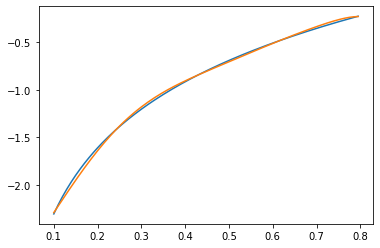

In [8]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

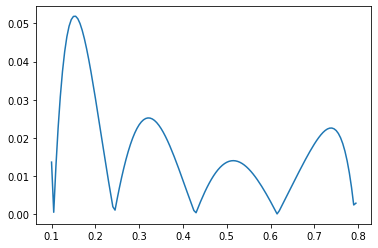

In [9]:
plt.plot(x, np.abs(y - np.log(x)))

C:\Users\DKR\Documents\Git Repositories\squlearn_fork\squlearn\src\squlearn\qnn\qnnr.py:79: UserWarning: The model is not fitted.
  warn("The model is not fitted.")


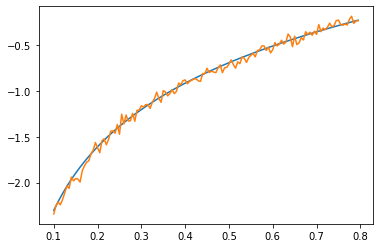

In [10]:
qasm = Executor("qasm_simulator")
qnn_qasm = QNNRegressor(
    pqc, ising_op, qasm, [SquaredLoss, VarianceLoss], SLSQP(), reg.param, reg.param_op
)
y = qnn_qasm.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

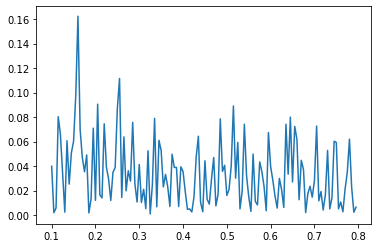

In [11]:
plt.plot(x, np.abs(y - np.log(x)))